In [48]:
import pandas as pd
import numpy as np
import matplotlib as pl
import matplotlib.pyplot as plt 
import mpl_toolkits.basemap as bm
import seaborn as sns
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [49]:
data = pd.read_csv("data.csv")

In [50]:
print data.head()
print data.columns
print len(data)

         DATE  TIME BOROUGH  ZIP CODE   LATITUDE  LONGITUDE  \
0  12/08/2015  9:56  QUEENS     11432  40.709754 -73.795618   
1  12/08/2015  0:01  QUEENS     11355  40.753722 -73.832821   
2  12/08/2015  0:51  QUEENS     11354  40.762954 -73.831957   
3  12/08/2015  0:45     NaN       NaN  40.714502 -73.896065   
4  12/08/2015  0:35   BRONX     10454  40.810053 -73.925144   

                    LOCATION           ON STREET NAME   CROSS STREET NAME  \
0  (40.7097537, -73.7956175)               167 STREET     HILLSIDE AVENUE   
1  (40.7537216, -73.8328215)  COLLEGE POINT BOULEVARD        MAPLE AVENUE   
2  (40.7629537, -73.8319573)              MAIN STREET  NORTHERN BOULEVARD   
3  (40.7145021, -73.8960647)    MOUNT OLIVET CRESCENT           62 STREET   
4  (40.8100528, -73.9251435)          EAST 138 STREET    ALEXANDER AVENUE   

  OFF STREET NAME         ...           CONTRIBUTING FACTOR VEHICLE 2  \
0             NaN         ...          Driver Inattention/Distraction   
1           

In [51]:
import datetime
nice_dates = data 
nice_dates["year"] = data["DATE"].apply(lambda x:int(x.split('/')[2]))
nice_dates["month"] = data["DATE"].apply(lambda x:int(x.split('/')[0]))
nice_dates["day"] = data["DATE"].apply(lambda x:int(x.split('/')[1]))
nice_dates["wday"] = data["DATE"].apply(lambda x: datetime.date(int(x.split('/')[2]), int(x.split('/')[0]), int(x.split('/')[1])).weekday() )
grouped_by_year = data.groupby(by=["year"])
grouped_by_month = data.groupby(by=["month"])
grouped_by_wday = data.groupby(by=["wday"])

year
2012    100522
2013    203689
2014    205928
2015    203608
dtype: int64


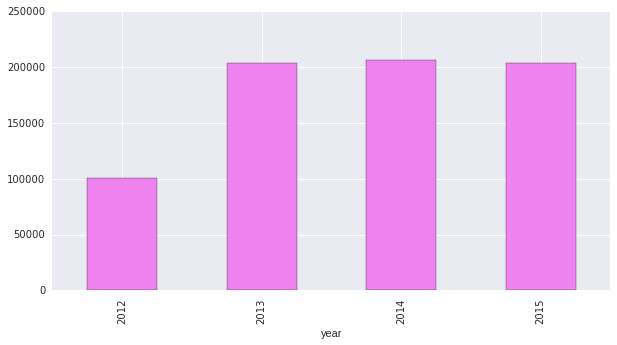

In [102]:
group_sizes = grouped_by_year.size()
fig = plt.figure(figsize=(10,5))
group_sizes.plot(kind='bar', color='violet')
print group_sizes

month
1     48392
2     45824
3     50293
4     49576
5     56011
6     55396
7     70756
8     69946
9     69797
10    72481
11    68601
12    56674
dtype: int64


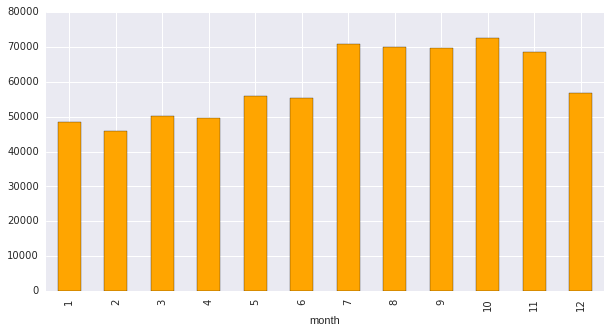

In [105]:
group_sizes = grouped_by_month.size()
fig = plt.figure(figsize=(10,5))
group_sizes.plot(kind='bar', color='orange')
print group_sizes

In [ ]:
group_sizes = grouped_by_wday.size()
fig = plt.figure(figsize=(10,5))
ax = group_sizes.plot(kind='bar', color='cyan')
ax.set_xticklabels(np.array(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']));
print group_sizes

grouped_by_wday

In [54]:
def transform(x):
    return "{0}/{1}/{2}".format(*x.split('/'))
nice_dates["DATE"] = data["DATE"].apply(transform)

def transform(x):
    s = x.split('/')
    return "{0}/{1}".format(s[0], s[2])

nice_dates["month_year"] = data["DATE"].apply(transform)

In [55]:
grouped_by_date = data.groupby(by=["DATE"])

In [56]:
grouped_by_vehicle = data.groupby(by="VEHICLE TYPE CODE 1")
print grouped_by_vehicle.groups.keys()

['TAXI', 'SMALL COM VEH(4 TIRES)', 'FIRE TRUCK', 'VAN', 'PEDICAB', 'BUS', 'UNKNOWN', 'SCOOTER', 'AMBULANCE', 'LIVERY VEHICLE', 'SPORT UTILITY / STATION WAGON', 'OTHER', 'MOTORCYCLE', 'BICYCLE', 'LARGE COM VEH(6 OR MORE TIRES)', 'PASSENGER VEHICLE', 'PICK-UP TRUCK']


In [11]:
#v = pd.tseries.index.DatetimeIndex(data["DATE"])

In [12]:
#data['date'] = v

(195,
 5,
 [-74.25559136315213, 40.496115395168516, 0.0, 0.0],
 [-73.70000906321046, 40.915532776502616, 0.0, 0.0],
 <matplotlib.collections.LineCollection at 0x7febda07df50>)

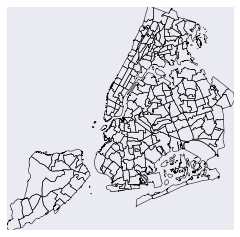

In [57]:

coords = (
           data["LONGITUDE"].min(), data["LATITUDE"].min(),
           data["LONGITUDE"].max(), data["LATITUDE"].max(),
        )

w, h = coords[2] - coords[0], coords[3] - coords[1]

m = bm.Basemap(
    projection='tmerc',
    lon_0=-74.130559,
    lat_0=40.703493,
    ellps = 'WGS84',
    llcrnrlon=coords[0],
    llcrnrlat=coords[1],
    urcrnrlon=coords[2],
    urcrnrlat=coords[3],
    lat_ts=0,
    resolution='i',
    suppress_ticks=True)

m.readshapefile(
    './ny/ny',
    'NY',
    zorder=2)


In [58]:
from shapely.geometry import Point, Polygon, MultiPoint, MultiPolygon
#print m.NY_info
df_map = pd.DataFrame({
    'poly': [Polygon(xy) for xy in m.NY],
    })
df_map['area_m'] = df_map['poly'].map(lambda x: x.area)
df_map['area_km'] = df_map['area_m'] / 100000

from descartes import PolygonPatch
df_map['patches'] = df_map['poly'].map(lambda x: PolygonPatch(
    x,
    fc='#000000',
    zorder=4
    ))


def get_marker_by_name(name):
    
    colors = ["green", "red", "yellow", "gray", "brown", "black", "pink"]
    shapes = ['o', 'v', '^', '<', '>', 's', 'p']
    
    
    h =  hash(name)%len(colors)
    return (colors[h], shapes[h])
    

    

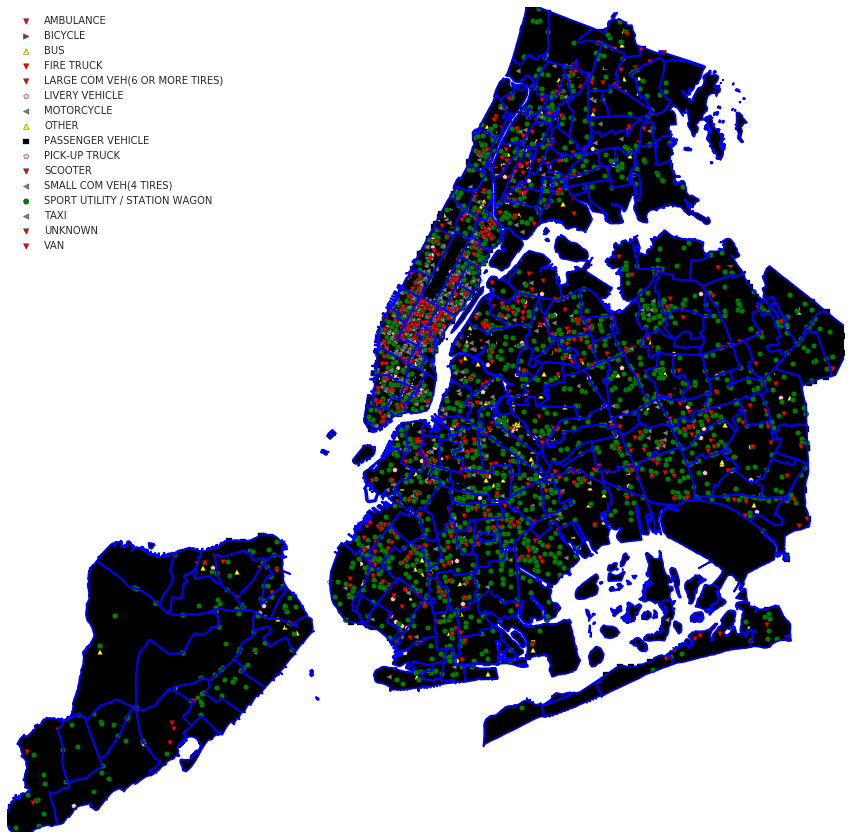

In [59]:
def draw_points(series, name = "", color = "green", max_num = None):
    if max_num is not None:
        series = series[:max_num]
    
    color, shape = get_marker_by_name(name)
    default_size = 30
    res = m.scatter(
        [p for p in series["LONGITUDE"]],
        [p for p in series["LATITUDE"]],
        s=default_size,
        marker=shape, 
        facecolor=color, 
        latlon=True,
        label=name, 
        zorder=1,
    )
    return res

from matplotlib.collections import PatchCollection
plt.clf()
fig = plt.figure()
ax = fig.add_subplot(111, axisbg='w', frame_on=False)

#for administrative boundaries
for info, shape in zip(m.NY_info, m.NY):
          x, y = zip(*shape) 
          m.plot(x, y,color='b')

#for ground
ax.add_collection(PatchCollection(df_map['patches'].values, match_original=True)) 

for idx,  groupdata in enumerate(data[data["year"] == 2015][:10000].groupby("VEHICLE TYPE CODE 1")):
    name, group = groupdata
    res = draw_points(group, name = name)
    plt.legend(loc=0)


fig.set_size_inches(15,15)


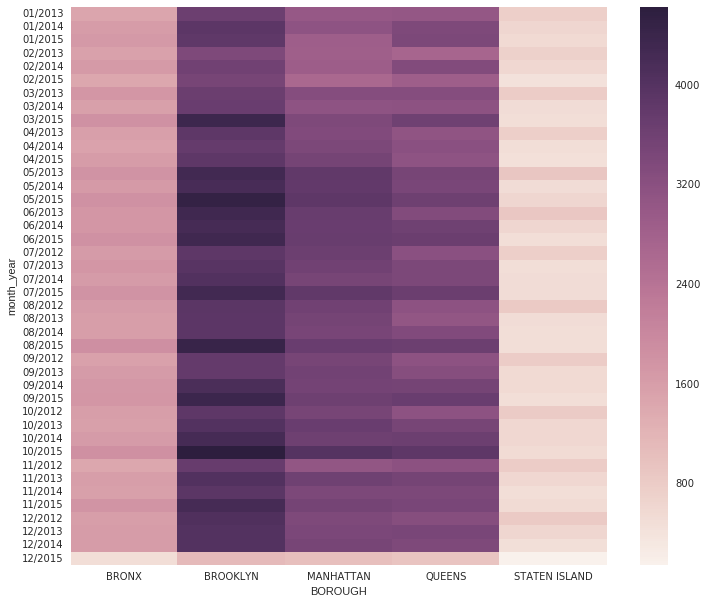

In [112]:
plt.figure(figsize=(12, 10))
t = nice_dates[["BOROUGH", "month_year"]]
names = t.groupby("BOROUGH").groups.keys()
g = t.groupby(["month_year", "BOROUGH"], as_index=False).size()
g = g.unstack(level=-1)

sns.heatmap(g)

In [ ]:
plt.figure(figsize=(12, 10))
t = nice_dates[["BOROUGH", "wday"]]
names = t.groupby("BOROUGH").groups.keys()
g = t.groupby(["wday", "BOROUGH"], as_index=False).size()
g = g.unstack(level=-1)

sns.heatmap(g, cmap="BuGn")

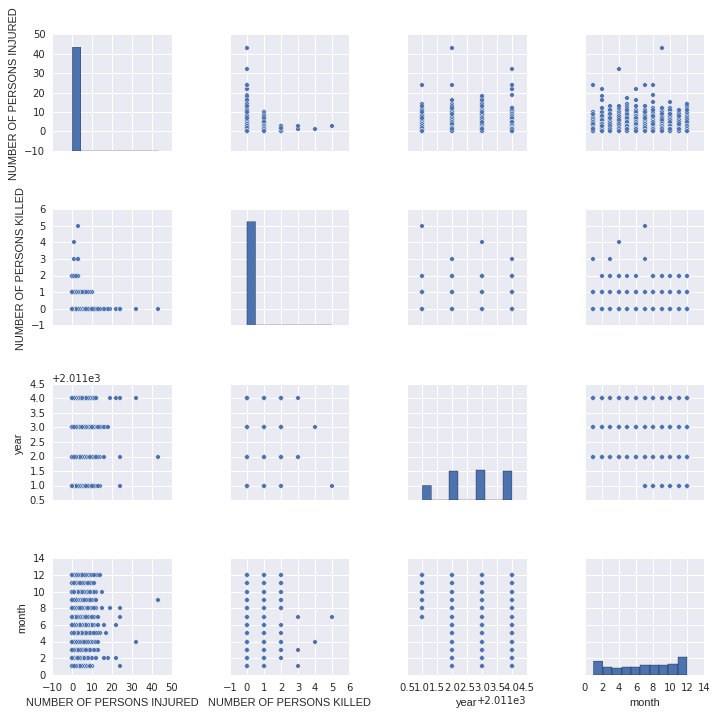

In [115]:
sns.pairplot(data[["NUMBER OF PERSONS INJURED", "NUMBER OF PERSONS KILLED", "year", "month"]])

In [67]:
nice_dates['hour'] = data["TIME"].apply(lambda x: int(x.split(':')[0]))

<Container object of 24 artists>

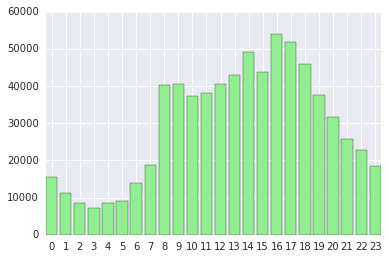

In [75]:
hours, accidents = zip(*list(nice_dates.groupby('hour').size().iteritems()))
plt.xticks(np.array(hours))
plt.bar(hours, accidents, align='center', color='lightgreen')

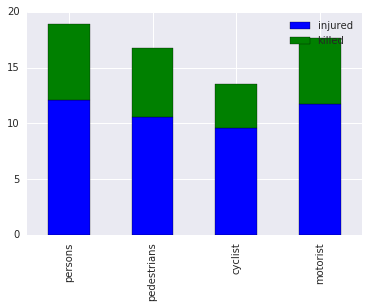

In [76]:
import math
deaths = np.zeros((4, 2))

for i, t in enumerate([u'NUMBER OF PERSONS ', u'NUMBER OF PEDESTRIANS ', u'NUMBER OF CYCLIST ', u'NUMBER OF MOTORIST ']):
    deaths[i][0] = math.log(data[t + 'INJURED'].sum())
    deaths[i][1] = math.log(data[t + 'KILLED'].sum())

deaths = pd.DataFrame(deaths, columns=['injured', 'killed'])
ax = deaths.plot(kind='bar', stacked=True)
ax.set_xticklabels(np.array(['persons', 'pedestrians', 'cyclist', 'motorist']));

<Container object of 5 artists>

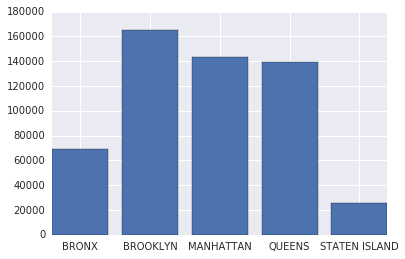

In [77]:
borough, accidents = zip(*list(data.groupby('BOROUGH').size().iteritems()))
plt.xticks(np.arange(len(borough)), np.array(borough))
plt.bar(range(len(borough)), accidents, align='center')

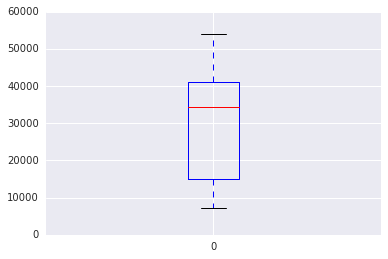

In [78]:
import pprint, math
injuries = data[u'NUMBER OF PERSONS KILLED'] + data[u'NUMBER OF PERSONS INJURED']
                    
for i, t in enumerate([u'NUMBER OF PEDESTRIANS ', u'NUMBER OF CYCLIST ', u'NUMBER OF MOTORIST ']):
    injuries += data[t + 'INJURED'] + data[t + 'KILLED']
    
injuries = injuries.apply(lambda x: math.log(1+x))

data['injuries'] = injuries

pd.DataFrame(data.groupby('hour').size()).boxplot();
pass

In [79]:
grouped_by_factor1 = data.groupby(by="CONTRIBUTING FACTOR VEHICLE 1")
grouped_by_factor2 = data.groupby(by="CONTRIBUTING FACTOR VEHICLE 2")
grouped_by_factor3 = data.groupby(by="CONTRIBUTING FACTOR VEHICLE 3")
print grouped_by_factor1.groups.keys()

['Tire Failure/Inadequate', 'Oversized Vehicle', 'Following Too Closely', 'Passenger Distraction', 'Pavement Slippery', 'Unspecified', 'Shoulders Defective/Improper', 'Physical Disability', 'Turning Improperly', 'Cell Phone (hands-free)', 'Fatigued/Drowsy', 'Driver Inexperience', 'Backing Unsafely', 'Steering Failure', 'Other Lighting Defects', 'Prescription Medication', 'Brakes Defective', 'View Obstructed/Limited', 'Other Vehicular', 'Unsafe Speed', 'Unsafe Lane Changing', 'Alcohol Involvement', 'Lost Consciousness', 'Passing or Lane Usage Improper', 'Cell Phone (hand-held)', 'Animals Action', 'Reaction to Other Uninvolved Vehicle', 'Traffic Control Disregarded', 'Fell Asleep', 'Failure to Yield Right-of-Way', 'Tow Hitch Defective', 'Accelerator Defective', 'Outside Car Distraction', 'Glare', 'Lane Marking Improper/Inadequate', 'Illness', 'Driver Inattention/Distraction', 'Pavement Defective', 'Pedestrian/Bicyclist/Other Pedestrian Error/Confusion', 'Headlights Defective', 'Windshiel

In [80]:
def processDict(x, y, d=None):
    if d is None:
        d = dict()
    for idx, key in enumerate(x):
        if key in d:
            d[key] += y[idx]
        else:
            d[key] = y[idx]
    return d

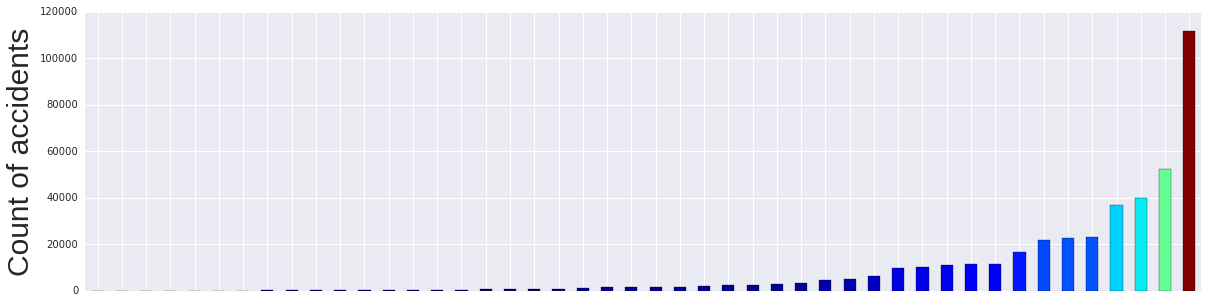

In [99]:
import pylab as pl

def plotdat(data_series, cnt):
    for i in range(0, len(data_series), cnt):
        tmp = data_series[i:i + cnt]
        if cnt >= len(data_series):
            tmp.index = np.array([''] * len(tmp))
        fig = plt.figure(figsize=(20, 5))
        plt.yticks(fontsize=50)
        cm = pl.get_cmap('jet')
        tmp.plot(kind='bar', fontsize=10, color=map(lambda c: cm(1.0 * c / max(data_series.values)), tmp.values))
        plt.ylabel('Count of accidents', fontsize=30)

factor1, accidents1 = zip(*list(grouped_by_factor1.size().iteritems()))
factor2, accidents2 = zip(*list(grouped_by_factor2.size().iteritems()))
factor3, accidents3 = zip(*list(grouped_by_factor3.size().iteritems()))
data_dict = processDict(factor1, accidents1)
data_dict = processDict(factor2, accidents2, data_dict)
data_dict = processDict(factor3, accidents3, data_dict)
pd_ser = pd.Series(data_dict)
pd_ser.sort()
pd_ser = pd_ser[:-1]
plotdat(pd_ser, len(pd_ser))

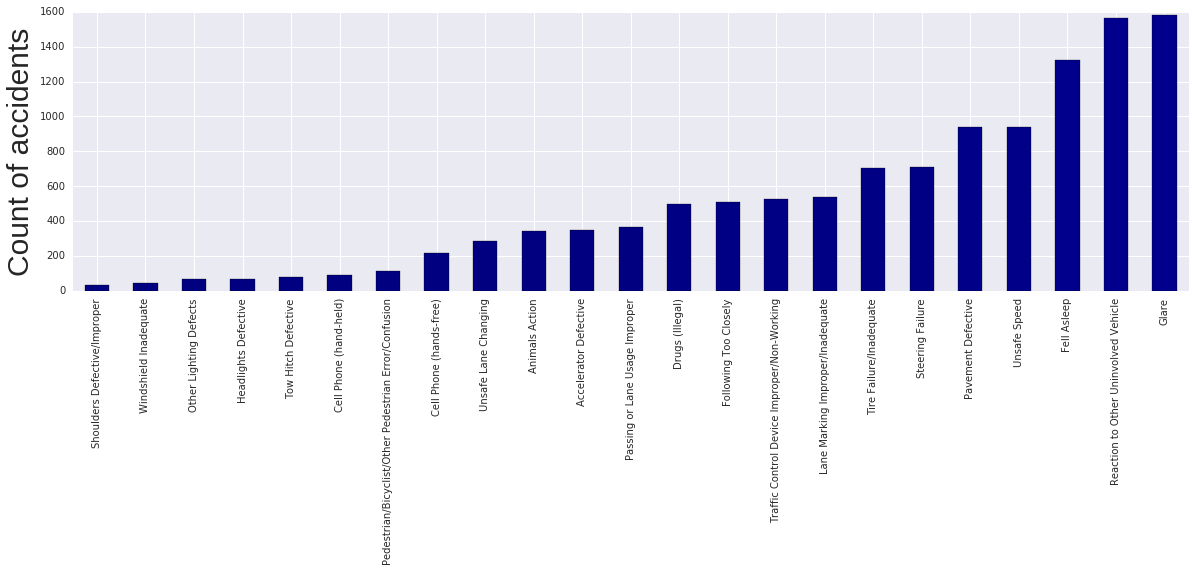

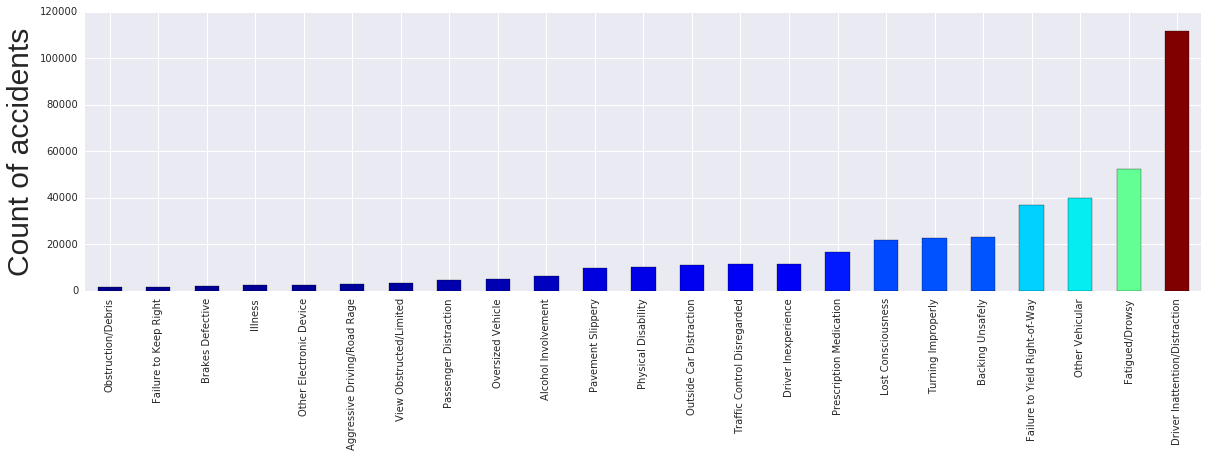

In [100]:
plotdat(pd_ser, len(pd_ser) / 2)

In [98]:
vehicle_types = list(data["VEHICLE TYPE CODE 1"]) + list(data["VEHICLE TYPE CODE 2"]) + list(data["VEHICLE TYPE CODE 3"])

In [84]:
from collections import Counter
vehicle_types_dict = Counter(vehicle_types)
print vehicle_types_dict

Counter({nan: 742106, 'PASSENGER VEHICLE': 710544, 'SPORT UTILITY / STATION WAGON': 306449, 'UNKNOWN': 96109, 'TAXI': 56082, 'VAN': 46199, 'OTHER': 42365, 'LARGE COM VEH(6 OR MORE TIRES)': 25741, 'BUS': 23891, 'SMALL COM VEH(4 TIRES)': 23848, 'PICK-UP TRUCK': 21189, 'BICYCLE': 18146, 'LIVERY VEHICLE': 16168, 'MOTORCYCLE': 7543, 'AMBULANCE': 3059, 'FIRE TRUCK': 1197, 'SCOOTER': 494, 'PEDICAB': 111})


In [85]:
vehicle_types_dict.pop(np.nan, None)

742106

In [86]:
print vehicle_types_dict

Counter({'PASSENGER VEHICLE': 710544, 'SPORT UTILITY / STATION WAGON': 306449, 'UNKNOWN': 96109, 'TAXI': 56082, 'VAN': 46199, 'OTHER': 42365, 'LARGE COM VEH(6 OR MORE TIRES)': 25741, 'BUS': 23891, 'SMALL COM VEH(4 TIRES)': 23848, 'PICK-UP TRUCK': 21189, 'BICYCLE': 18146, 'LIVERY VEHICLE': 16168, 'MOTORCYCLE': 7543, 'AMBULANCE': 3059, 'FIRE TRUCK': 1197, 'SCOOTER': 494, 'PEDICAB': 111})


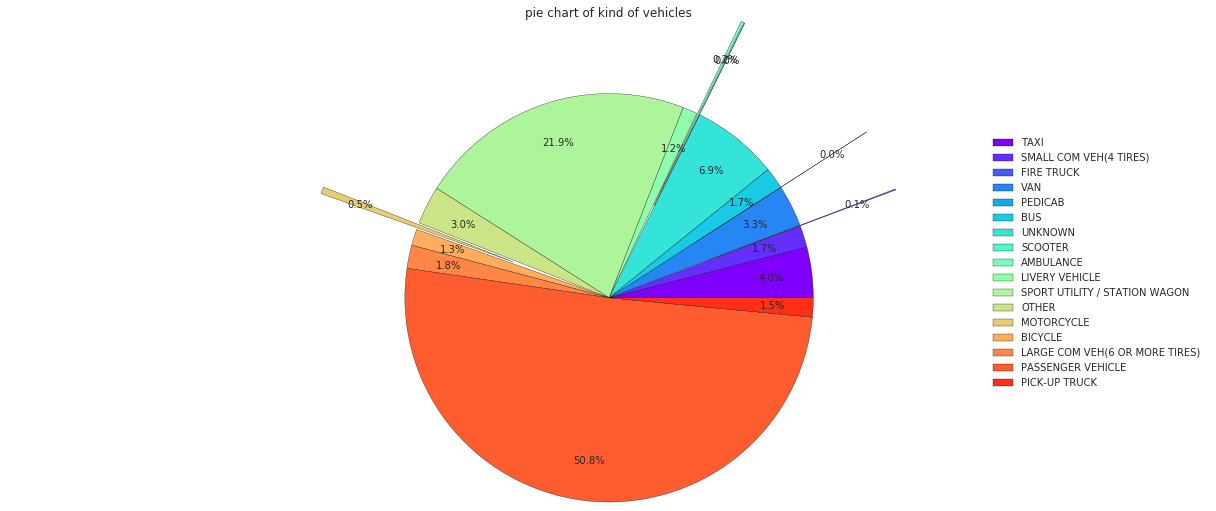

In [172]:
import random
items = vehicle_types_dict.items()

types = [it[0] for it in items]
counts = [vehicle_types_dict[it] for it in types]
explode = [0] * len(types)

for i in xrange(len(counts)):
    if counts[i] * 1.0 / sum(counts) <= 0.01:
        explode[i] = 0.5
#cm = pl.get_cmap('nipy_spectral')
cm = pl.get_cmap('rainbow')
plt.figure(figsize=(17, 7))
patches, texts, autotexts  = plt.pie(x=counts, explode=explode, autopct='%1.1f%%', 
                                     pctdistance=0.8, colors=[cm(i * 1.0 / len(counts)) for i in xrange(len(counts))])
plt.legend(patches, types, loc="right")
plt.axis('equal')
plt.tight_layout()
plt.title("pie chart of kind of vehicles")
plt.show()

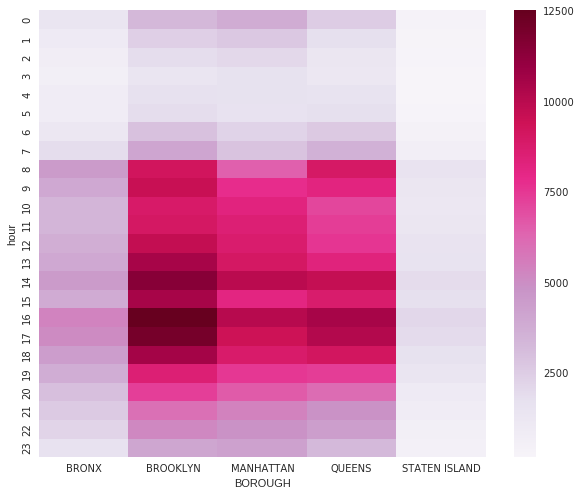

In [117]:
plt.figure(figsize=(10, 8))
t = nice_dates[["BOROUGH", "hour"]]
g = t.groupby(["hour", "BOROUGH"], as_index=False).size()
g = g.unstack(level=-1)

sns.heatmap(g, cmap='PuRd')

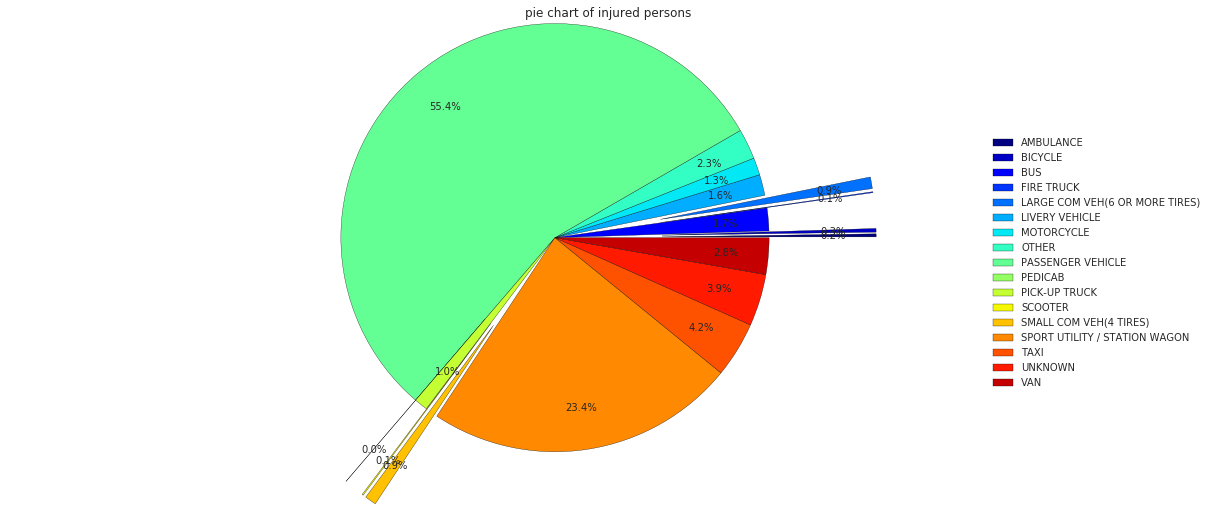

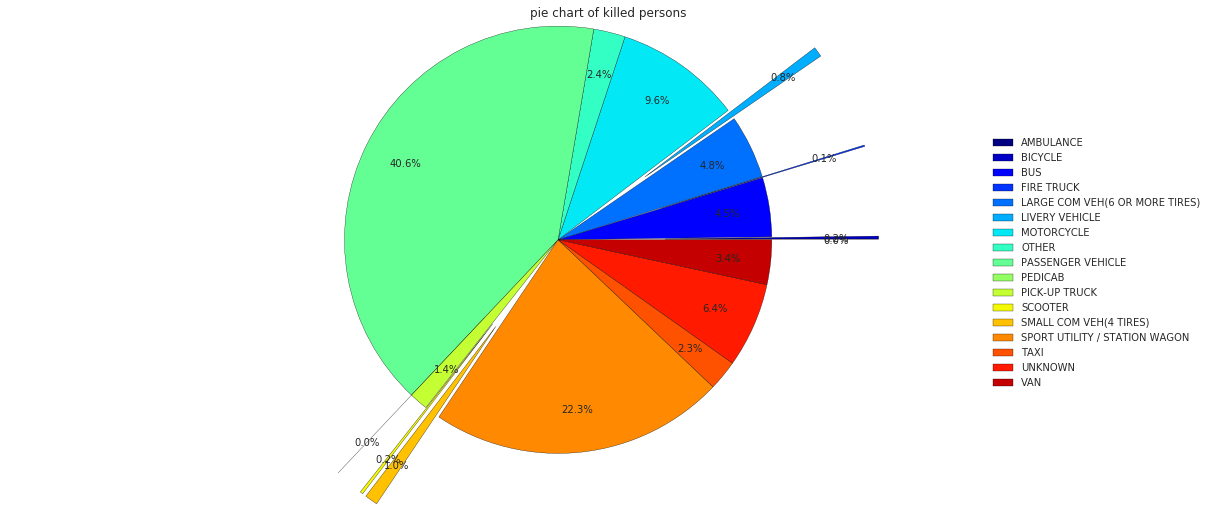

In [202]:
t = nice_dates[["NUMBER OF PERSONS INJURED", "NUMBER OF PERSONS KILLED", "VEHICLE TYPE CODE 1"]]
g = t.groupby("VEHICLE TYPE CODE 1")
inj = g["NUMBER OF PERSONS INJURED"].sum()
kil = list(g["NUMBER OF PERSONS KILLED"].sum())
veh_names = list(inj.index)
inj = list(inj)

cm = pl.get_cmap('jet')
plt.figure(figsize=(17, 7))
explode = [0] * len(veh_names)
for i in xrange(len(veh_names)):
    if inj[i] * 1.0 / sum(inj) <= 0.01:
        explode[i] = 0.5
patches, texts, autotexts  = plt.pie(x=inj, explode=explode, hold=True, autopct='%1.1f%%', 
                                     pctdistance=0.8, colors=[cm(i * 1.0 / len(inj)) for i in xrange(len(inj))])
plt.legend(patches, veh_names, loc="right")
plt.axis('equal')
plt.tight_layout()
plt.title("pie chart of injured persons")
plt.show()
                             
plt.figure(figsize=(17, 7))
explode = [0] * len(veh_names)
for i in xrange(len(veh_names)):
    if kil[i] * 1.0 / sum(kil) <= 0.01:
        explode[i] = 0.5
patches, texts, autotexts = plt.pie(x=kil, explode=explode, hold=True, autopct='%1.1f%%', 
                                     pctdistance=0.8, colors=[cm(i * 1.0 / len(inj)) for i in xrange(len(inj))])
plt.legend(patches, veh_names, loc="right")
plt.axis('equal')
plt.tight_layout()
plt.title("pie chart of killed persons")
plt.show()

In [ ]:
plt.clf()
fig = plt.figure()
ax = fig.add_subplot(111, axisbg='w', frame_on=False)

#for administrative boundaries
for info, shape in zip(m.NY_info, m.NY):
          x, y = zip(*shape) 
          m.plot(x, y,color='b')

#for ground
ax.add_collection(PatchCollection(df_map['patches'].values, match_original=True)) 

for idx,  groupdata in enumerate(data[data["year"] == 2015][:10000].groupby("VEHICLE TYPE CODE 1")):
    name, group = groupdata
    res = draw_points(group, name = name)
    plt.legend(loc=0)


fig.set_size_inches(15,15)

In [ ]:
sns.pairplot(data[["NUMBER OF PERSONS INJURED", "NUMBER OF PERSONS KILLED", "wday"]])

In [ ]:
pd.DataFrame(data.groupby('wday').size()).boxplot();